In [1]:
import Pkg
packages_added = [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]
for pkg in ("Distributions", "StatsFuns")
    if pkg in packages_added
        println("$(pkg).jl is already added.")
    else
        println("$(pkg).jl is not added yet, do let's add it.")
        Pkg.add(pkg)
    end
end

Distributions.jl is already added.
StatsFuns.jl is already added.


In [2]:
using Random
using Distributions
using StatsFuns
using Plots
default(fmt=:png, legendfontsize=12)
safediv(x, y) = x == 0 ? zero(x/y) : x/y

varstab_bin(p) = asin(2p - 1)

function expectval(f, bin::Binomial)
    sum(f(x) * pdf(bin, x) for x in support(bin))
end

function variance(f, bin::Binomial)
    mu = expectval(f, bin)
    sigma2 = expectval(x -> (f(x) - mu)^2, bin)
end

function variance_varstab_bin(n, p)
    variance(k -> sqrt(n) * varstab_bin(k/n), Binomial(n, p))
end

function variance_logit(n, p)
    variance(k -> 0 < k < n ? sqrt(n)/2 * logit(k/n) : 0.0, Binomial(n, p))
end

function pvalue_binomial_wald(k, n, p)
    phat = k/n
    z = safediv(phat - p, sqrt(phat*(1 - phat)/n))
    2ccdf(Normal(), abs(z))
end

function pvalue_binomial_score(k, n, p)
    phat = k/n
    z = safediv(phat - p, sqrt(p*(1 - p)/n))
    2ccdf(Normal(), abs(z))
end

function pvalue_binomial_varstab(k, n, p)
    phat = k/n
    correction = (2p-1)/(4n*sqrt(p*(1-p)))
    z = sqrt(n) * (varstab_bin(phat) - varstab_bin(p) - correction)
    2ccdf(Normal(), abs(z))
end

function alpha_erroer_rate(pvaluefunc, bin::Binomial; alpha=0.05)
    n, p = params(bin)
    f(k) = (pvaluefunc(k, n, p) < alpha)
    expectval(f, bin)
end

function plot_comparison_varstab_logit(; n = 10, f=trues(2), kwargs...)
    plot()
    f[1] && plot!(p -> variance_varstab_bin(n, p), 0, 1; label="var.stab.")
    f[2] && plot!(p -> variance_logit(n, p), 0, 1; label="logit")
    hline!([1]; c=:black, ls=:dot, label="")
    plot!(legend=:top)
    plot!(; kwargs...)
end

function plot_pvalue_functions(; k=1, n=10, p=0.0, kwargs...)
    @show k, n, p
    @show pvalue_binomial_varstab.(k, n, p)
    @show pvalue_binomial_score.(k, n, p)
    @show pvalue_binomial_wald.(k, n, p)
    plot()
    plot!(p -> pvalue_binomial_varstab(k, n, p), 0, 1; label="var.stab.")
    plot!(p -> pvalue_binomial_score(k, n, p), 0, 1; label="score", ls=:dash)
    plot!(p -> pvalue_binomial_wald(k, n, p), 0, 1; label="Wald", ls=:dot)
    plot!(xtick=0:0.1:1, ytick=0:0.05:1)
    title!("P-value functions for k=$k, n=$n")
    plot!(; kwargs...)
end

function plot_alpha_error_rates(; alpha=0.5, n=10, ps=range(0, 1, 1001), f=trues(3), kwargs...)
    plot()
    f[1] && plot!(ps, p -> alpha_erroer_rate(pvalue_binomial_varstab, Binomial(n, p); alpha); label="var.stab.", c=1)
    f[2] && plot!(ps, p -> alpha_erroer_rate(pvalue_binomial_score, Binomial(n, p); alpha); label="score", c=2)
    f[3] && plot!(ps, p -> alpha_erroer_rate(pvalue_binomial_wald, Binomial(n, p); alpha); label="wald", ls=:dot, c=3)
    hline!([alpha]; label="", ls=:dot, c=:black)
    plot!(xtick=0:0.1:1, ytick=0:0.05:1)
    plot!(legend=:top)
    title!("alpha error rates for n=$n, alpha=$alpha")
    plot!(; kwargs...)
end

plot_alpha_error_rates (generic function with 1 method)

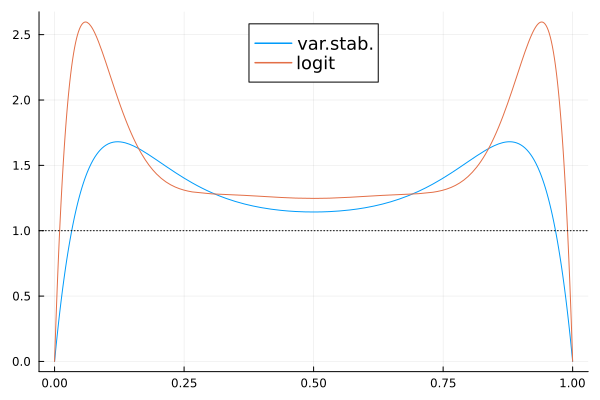

In [3]:
plot_comparison_varstab_logit(; n = 10)

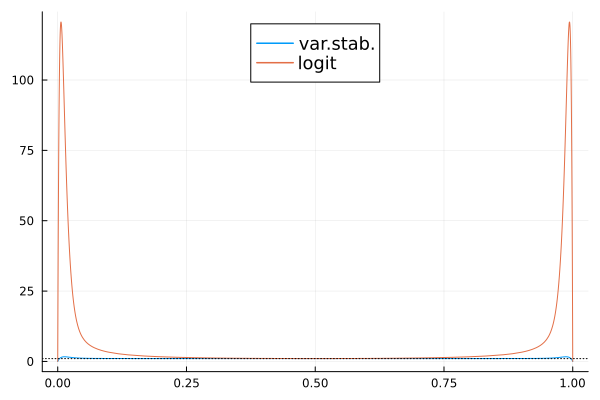

In [4]:
plot_comparison_varstab_logit(; n = 100)

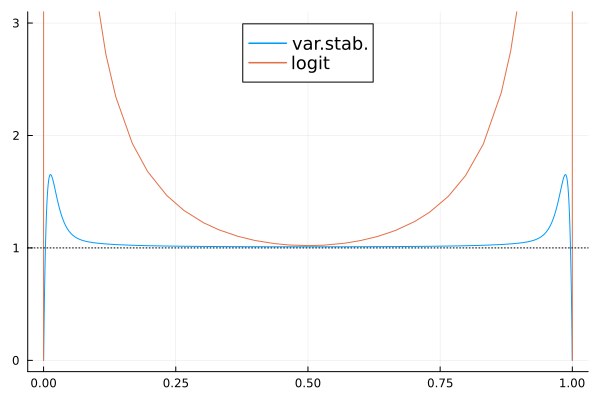

In [5]:
plot_comparison_varstab_logit(; n = 100, ylim=(-0.1, 3.1))

(k, n, p) = (1, 10, (0.0, 0.4))
pvalue_binomial_varstab.(k, n, p) = (0.0, 0.02361471143166702)
pvalue_binomial_score.(k, n, p) = (0.0, 0.052807511416113576)
pvalue_binomial_wald.(k, n, p) = (0.29184054514378843, 0.0015654022580025488)


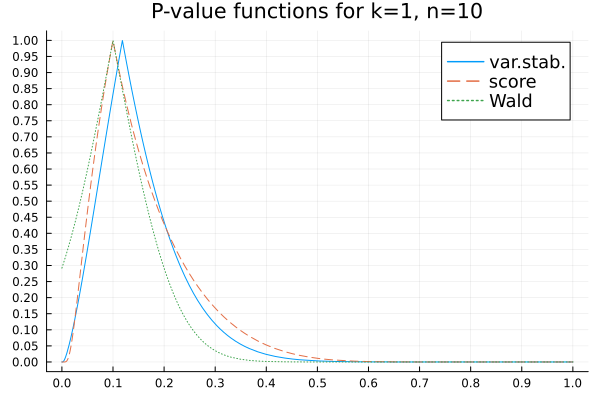

In [6]:
plot_pvalue_functions(; k=1, n=10, p=(0.0, 0.4))

(k, n, p) = (2, 10, (0.0, 0.5))
pvalue_binomial_varstab.(k, n, p) = (0.0, 0.04185799934159657)
pvalue_binomial_score.(k, n, p) = (0.0, 0.057779571123597245)
pvalue_binomial_wald.(k, n, p) = (0.11384629800665803, 0.017706065807366635)


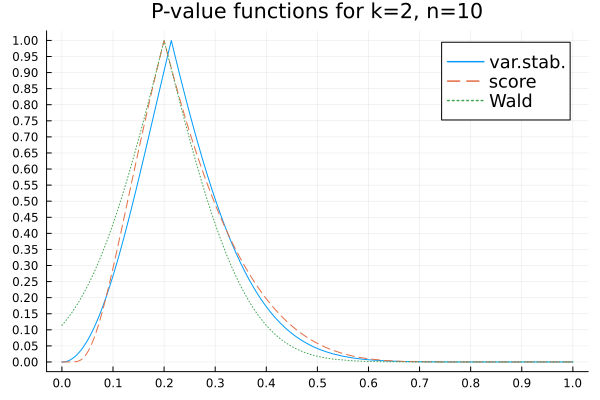

In [7]:
plot_pvalue_functions(; k=2, n=10, p=(0.0, 0.5))

(k, n, p) = (20, 100, 0.285)
pvalue_binomial_varstab.(k, n, p) = 0.04926751316493897
pvalue_binomial_score.(k, n, p) = 0.059704390171571586
pvalue_binomial_wald.(k, n, p) = 0.03358661289689768


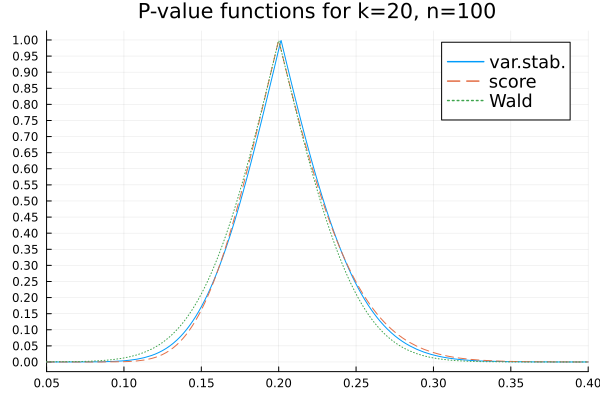

In [8]:
plot_pvalue_functions(; k=20, n=100, p=0.285, xlim=(0.05, 0.4), xtick=0:0.05:1)

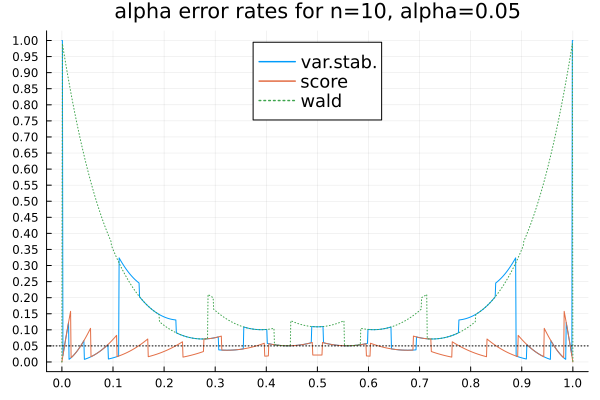

In [9]:
plot_alpha_error_rates(; alpha=0.05, n=10)

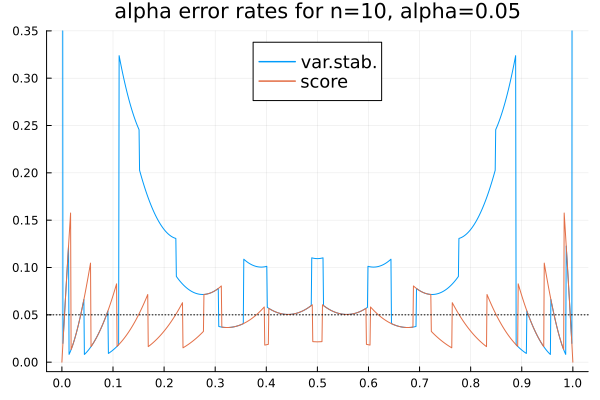

In [10]:
plot_alpha_error_rates(; alpha=0.05, n=10, f=Bool[1,1,0], ylim=(-0.01, 0.35))

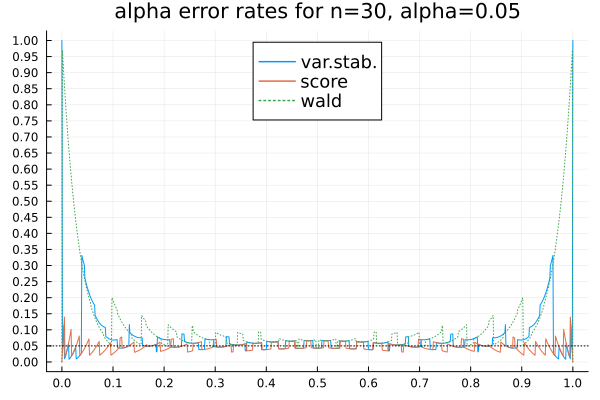

In [11]:
plot_alpha_error_rates(; alpha=0.05, n=30)

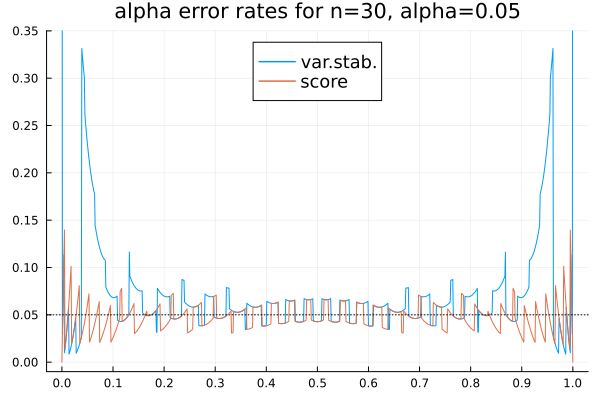

In [12]:
plot_alpha_error_rates(; alpha=0.05, n=30, f=Bool[1,1,0], ylim=(-0.01, 0.35))

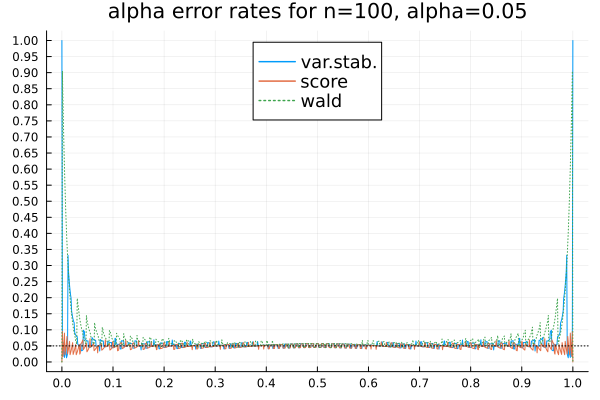

In [13]:
plot_alpha_error_rates(; alpha=0.05, n=100)

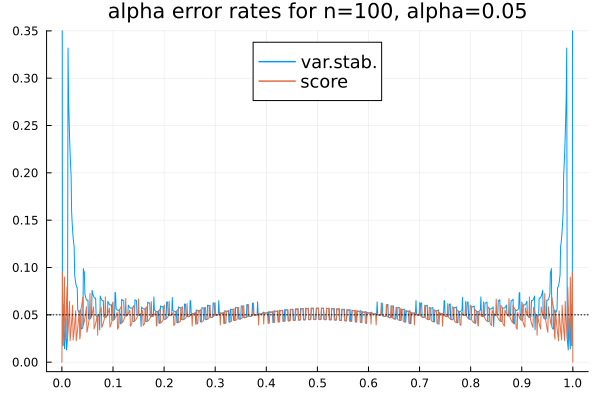

In [14]:
plot_alpha_error_rates(; alpha=0.05, n=100, f=Bool[1,1,0], ylim=(-0.01, 0.35))

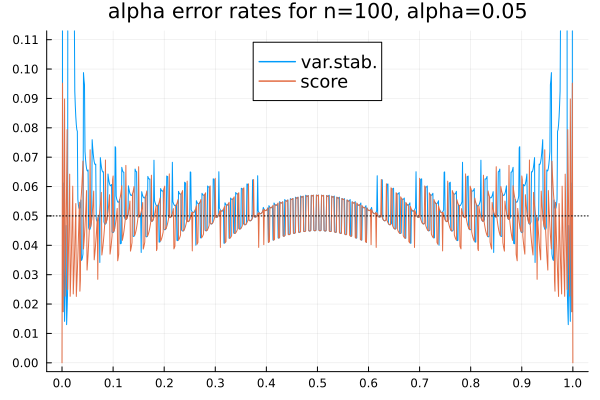

In [15]:
plot_alpha_error_rates(; alpha=0.05, n=100, f=Bool[1,1,0], ylim=(-0.003, 0.113), ytick=0:0.01:1)

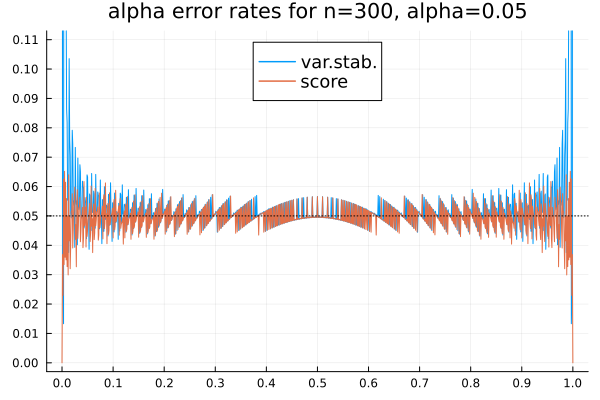

In [16]:
plot_alpha_error_rates(; alpha=0.05, n=300, f=Bool[1,1,0], ytick=0:0.01:1, ylim=(-0.003, 0.113))

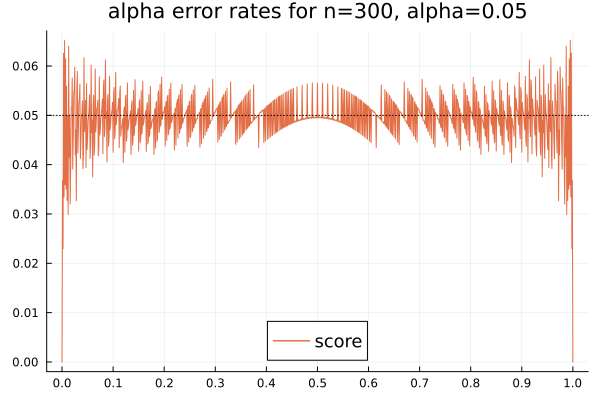

In [17]:
plot_alpha_error_rates(; alpha=0.05, n=300, f=Bool[0,1,0], ytick=0:0.01:1, legend=:bottom)